In [10]:
# https://www.kaggle.com/datasets/stefanlarson/outofscope-intent-classification-dataset?resource=download

In [11]:
# import kagglehub

# kagglehub.login()

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stefanlarson/outofscope-intent-classification-dataset",path='/storage')

print("Path to dataset files:", path)

KaggleApiHTTPError: 404 Client Error.

Resource not found at URL: https://www.kaggle.com/datasets/stefanlarson/outofscope-intent-classification-dataset/versions/1
Please make sure you specified the correct resource identifiers.

In [13]:
# !pip install datasets torchinfo

# Libraries

In [15]:
import os
import json

import pandas as pd
import numpy as np
from datasets import load_dataset
from torch.utils.data import Dataset, random_split
import torch
from transformers import AutoTokenizer
from tqdm import tqdm
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from model_blocks import *
from pathlib import Path
import torchinfo

In [16]:
import utils 

# Config

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
n_epochs = 20

seed = 42
torch.manual_seed(seed)


# Data preprocessing

In [19]:
os.listdir(path)

['is_test.json',
 'is_train.json',
 'is_val.json',
 'oos_test.json',
 'oos_train.json',
 'oos_val.json']

In [20]:
with open(os.path.join(path, 'is_train.json'), 'r') as file:
    train_data = json.load(file)
with open(os.path.join(path, 'is_val.json'), 'r') as file:
    val_data = json.load(file)

In [21]:
for i in range(len(train_data)):
    print("Train data:")
    print(train_data[i])
    print(train_data[i][0])
    print(train_data[i][1])
    print("\n validation data:")
    print(val_data[i])
    print(val_data[i][0])
    print(val_data[i][1])
    break

Train data:
['what expression would i use to say i love you if i were an italian', 'translate']
what expression would i use to say i love you if i were an italian
translate

 validation data:
['in spanish, meet me tomorrow is said how', 'translate']
in spanish, meet me tomorrow is said how
translate


In [22]:
def data_preprocessing(ds):
    prompt = []
    label = []
    ds_upd = pd.DataFrame()
    
    for indiv_data in ds:
        prompt.append(indiv_data[0])
        label.append(indiv_data[1])
    ds_upd["prompt"] = prompt
    ds_upd["label_str"] = label
    
    unique_classes = ds_upd['label_str'].unique()
    class_to_id = {cls: idx for idx, cls in enumerate(unique_classes)}
    ds_upd['label'] = ds_upd['label_str'].map(class_to_id)
    
    return ds_upd, unique_classes
        

In [23]:
train_data, unique_classes = data_preprocessing(train_data)
val_data, unique_classes = data_preprocessing(val_data)

In [24]:
train_data.sample(5)

,prompt,label_str,label
9745,do you know why i can't log into my bank account,account_blocked,97
14662,i'm out of soap so will you order me some more,order,146
9292,would you say that red lobster's pretty buy at...,how_busy,92
13408,in my tank how much gas is there,gas,134
2978,who is the creator of this ai,who_made_you,29


In [27]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


<Axes: ylabel='text_len'>

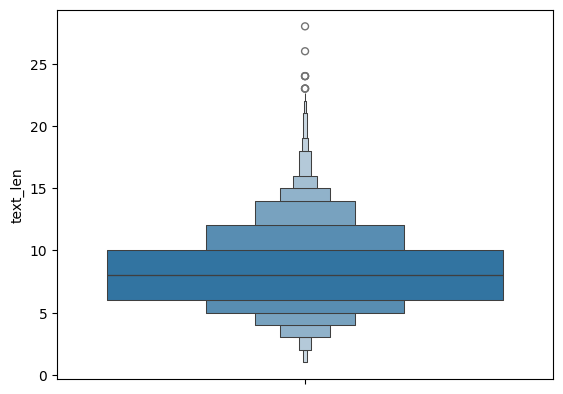

,prompt,label_str,label,text_len
4249,can you tell me what to do as i am in the airp...,lost_luggage,42,28
12563,i want to buy a plane ticket to travel from mi...,book_flight,125,26
12565,i want to book a flight reservation from texas...,book_flight,125,24
1535,can you find out if my application at smith ba...,application_status,15,24
2402,i think we should reserve dad's regular table ...,restaurant_reservation,24,24
...,...,...,...,...
9674,goodbye!,goodbye,96,1
11881,bonjour,greeting,118,1
11899,salutations!,greeting,118,1
11878,aloha,greeting,118,1


#  Data processing

## Tokenizer setup

In [15]:
corpus = " ".join(train_data["prompt"])
tokenizer = utils.selfTokenizer(corpus)
print(tokenizer.encode("i need you to translate the sentence"))
print(tokenizer.decode([5140, 5500, 539, 3868, 420, 3175, 2041]))
del tokenizer, corpus

[4130, 4491, 2252, 5152, 5286, 579, 4190]
class fair, chat, persons jfk disney trader


We could use our own self made tokenizer class, hwoever GPT-2 uses BytePair encoding as tokenizer, and we would follow the same, as it allows to handle out-of-vocab words.

In [17]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("i need you to translate the sentence",allowed_special="all"))
print(tokenizer.decode([72, 761, 345, 284, 15772, 262, 6827]))

[72, 761, 345, 284, 15772, 262, 6827]
i need you to translate the sentence


In [36]:
tokenizer = utils.get_or_build_tokenizer(train_data)
tokenizer.encode("i need you to translate the sentence").ids
tokenizer.decode([4, 21, 9, 6, 646, 7, 2704])

'i need you to translate the sentence'

In [37]:
import seaborn as sns
train_data["text_len"] = train_data['prompt'].apply(lambda x: len(tokenizer.encode(x).tokens))

<Axes: ylabel='text_len'>

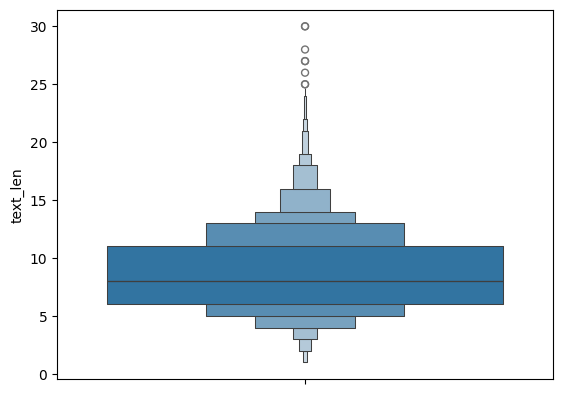

In [38]:
sns.boxenplot(train_data['text_len'])

In [39]:
train_data.sort_values(by='text_len',ascending=False)

,prompt,label_str,label,text_len
4569,my car's been throwing cels that i think are o...,oil_change_when,45,30
2402,i think we should reserve dad's regular table ...,restaurant_reservation,24,30
4249,can you tell me what to do as i am in the airp...,lost_luggage,42,28
14102,i want to rent the cheapest car for charlottes...,car_rental,141,27
10636,i'd like you to book me a room in austin near ...,book_hotel,106,27
...,...,...,...,...
9685,buhbye,goodbye,96,1
4626,correct,yes,46,1
4600,yep,yes,46,1
10828,weather,weather,108,1


## Dataset loading

In [18]:
max_seq_len = len(max(train_data['prompt'],key=len))
print(max_seq_len)
train_data = utils.promptDataset(tokenizer,train_data,max_seq_len+1)
val_data = utils.promptDataset(tokenizer,val_data,max_seq_len+1)

136


In [24]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=10,shuffle=True)
val_loader = torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=False)
# data_iter = iter(train_loader)
# inputs, targets = next(data_iter)
# print("Inputs:\n", inputs)
# print("\nTargets:\n", targets)


# Model building

In [25]:
def build_encoder_only_transformer(src_vocab_size, n_classes,
                                   seq_len, embedding_dim=512,
                                   N =6, h=8, dropout=0.01, d_ff=2048):

    src_embed = InputEmbeddings(src_vocab_size,embedding_dim)
    src_pos = PositionalEncoding(embedding_dim, seq_len, dropout)

    encoder_blocks = []
    for _ in range(N):
        self_attention_block = MultiHeadAttention(seq_len, embedding_dim, h, dropout)
        feed_forward_block = FeedForwardBlock(d_ff,embedding_dim, dropout)
        enc = encoder_block(self_attention_block,feed_forward_block,dropout)
        encoder_blocks.append(enc)

    encoder = Encoder(nn.ModuleList(encoder_blocks))
    transformer = EncoderOnlyTransformer(src_embed, src_pos, encoder,
                                         n_classes, src_vocab_size,
                                         embedding_dim)

    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

In [39]:
def get_model(tokenizer,n_classes):
    model = build_encoder_only_transformer(tokenizer.max_token_value, n_classes, max_seq_len)
    return model.to(device)

In [40]:
print(len(unique_classes))

150


In [1]:
([1,0,0] == [0,0,0]).sum()

AttributeError: 'bool' object has no attribute 'sum'

In [49]:
def train_epoch(model,dataloader, device=device):
    losses, acc, count = [], 0, 0
    batch_iterator = tqdm(enumerate(dataloader),total=len(dataloader))
    for idx, batch in batch_iterator:
        encoder_input = batch[0].to(device)
        label = batch[1].to(device)

        optimizer.zero_grad()
        output = model.encode(encoder_input,None).to(device)
        # output = output[:, -1, :] # Get predictions for the last token
        loss = loss_fn(output, label).to(device)
        loss.backward()
        optimizer.step()

        # global_step += 1

        losses.append(loss.item())
        predicted_class = torch.argmax(output, dim=-1)

        batch_correct = (predicted_class == label).sum().item()
        batch_accuracy = batch_correct / len(label)
        acc += batch_correct
        count += len(label)

        batch_iterator.set_postfix({"train_loss": f"{loss.item():6.3f}",
                                     "batch_acc": f"{batch_accuracy:.4f}",
                                     "train_acc": f"{acc/count:.4f}"})

    return np.mean(losses), acc/count

In [50]:
def evaluate_model(model, test_data_batch, device=device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in test_data_batch:
            encoder_input = batch[0].to(device)
            label = batch[1].to(device)
            output = model.encode(encoder_input, None)

            # import pdb; pdb.set_trace()
            # output = output[:, -1, :]  # Get predictions for the last token
            loss = loss_fn(output, label).to(device)

            predicted_class = torch.argmax(output, dim=-1)
            batch_correct = (predicted_class == label).sum().item()
            batch_accuracy = batch_correct / len(label)
            acc = batch_correct
            count = len(label)

            losses.append(loss.item())
    return np.mean(losses), acc/count

In [51]:
def train(model, train_loader, test_loader, epochs):
    for ep in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader)
        val_loss, val_acc = evaluate_model(model, test_loader)
        print(f'ep {ep}: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')

In [52]:
model = get_model(tokenizer,n_classes=len(unique_classes))
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
EncoderOnlyTransformer                                  --
├─InputEmbeddings: 1-1                                  --
│    └─Embedding: 2-1                                   25,731,072
├─PositionalEncoding: 1-2                               --
│    └─Dropout: 2-2                                     --
├─Encoder: 1-3                                          --
│    └─ModuleList: 2-3                                  --
│    │    └─encoder_block: 3-1                          3,150,342
│    │    └─encoder_block: 3-2                          3,150,342
│    │    └─encoder_block: 3-3                          3,150,342
│    │    └─encoder_block: 3-4                          3,150,342
│    │    └─encoder_block: 3-5                          3,150,342
│    │    └─encoder_block: 3-6                          3,150,342
├─Linear: 1-4                                           76,950
Total params: 44,710,074
Trainable params: 44,710,074
No

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=10**-4,eps= 1e-9)
loss_fn = nn.CrossEntropyLoss()

In [54]:
train(model, train_loader, val_loader, epochs=1)

  0%|          | 0/1500 [00:00<?, ?it/s]


IndexError: index out of range in self

In [ ]:
def predict_labels(model, tokenizer, prompts, class_to_id):
    model.eval()
    predictions = []

    with torch.no_grad():
        for prompt in prompts:
            enc_input_tokens = tokenizer.encode(prompt).ids
            encoder_input = torch.tensor(enc_input_tokens, dtype=torch.int64).unsqueeze(0).to(device)

            output = model.encode(encoder_input, None)
            # output = output[:, -1, :]  # Get predictions for the last token
            predicted_class = torch.argmax(output, dim=-1).item()
            predictions.append(predicted_class)

    # Map predicted classes back to text labels
    id_to_class = {idx: cls for cls, idx in class_to_id.items()}
    predicted_labels = [id_to_class[pred] for pred in predictions]
    return predicted_labels

In [ ]:
def get_sample_prompts_and_labels(ds_upd, sample_size):

    sampled_data = ds_upd.sample(n=sample_size)

    prompts = sampled_data['prompt'].tolist()
    actual_labels = sampled_data['completion'].map(lambda x: {v: k for k, v in class_to_id.items()}[x]).tolist()

    return prompts, actual_labels

In [ ]:
sample_size = 5

sample_prompts, actual_labels = get_sample_prompts_and_labels(ds_upd, sample_size)

predicted_labels = predict_labels(model, tokenizer, sample_prompts, class_to_id)

for prompt, actual, predicted in zip(sample_prompts, actual_labels, predicted_labels):
    print(f"Prompt: {prompt}\nActual Label: {actual}\nPredicted Label: {predicted}\n")
